**Uncomment the cell below if running on Google Colab or Kaggle**

In [1]:
# %%capture
# !pip3 install -U torch torchvision torchaudio
# !pip3 install -U fastai
# !pip3 install -U kaggle
# !pip3 install -U Pillow

**Note for Colab:**  You must restart the runtime in order to use newly installed version of Pillow.

**Import all fastai computer vision functionality**

In [2]:
from fastai.vision.all import *

### Kaggle API
* [GitHub Repository](https://github.com/Kaggle/kaggle-api)
* [Documentation](https://github.com/Kaggle/kaggle-api#competitions)
* Install: `pip install kaggle`
* Need to get an API Key for your Kaggle account
    * [https://www.kaggle.com/me/account](https://www.kaggle.com/me/account)

**Enter Kaggle username and API token**

In [3]:
creds = '{"username":"","key":""}'

**Save Kaggle credentials if none are present**
* **Source:** [https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
# Save API key to a json file if it does not already exist
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

**Import Kaggle API**

In [5]:
from kaggle import api

**Define method to display default function arguments**

In [6]:
import inspect
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def inspect_default_args(target, annotations: bool=False):
    # Get the argument names
    args = inspect.getfullargspec(target).args
    # Get the default values
    defaults = inspect.getfullargspec(target).defaults

    index = ["Default Value"]

    # Pad defaults
    defaults = [None]*(len(args)-len(defaults)) + list(defaults)
    if annotations:
        index.append("Annotation")
        annotations = inspect.getfullargspec(target).annotations.values()
        # Pad annotations
        annotations = [None]*(len(args)-len(annotations)) + list(annotations)
        default_args = {arg:[df, annot] for arg,df,annot in zip(args, defaults, annotations)}
    else:
        default_args = {arg:[default] for arg,default in zip(args, defaults)}
        
    return pd.DataFrame(default_args, index=index).T

**Define path to dataset**

In [7]:
kaggle_dataset = 'belalelwikel/asl-and-some-words'
archive_dir = URLs.path()
dataset_dir = archive_dir/'../data'
dataset_name = 'asl-and-some-words'
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

**Define method to extract the dataset from an archive file**

In [8]:
def file_extract(fname, dest=None):
    "Extract `fname` to `dest` using `tarfile` or `zipfile`."
    if dest is None: dest = Path(fname).parent
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

**Download the dataset if it is not present**

In [9]:
if not archive_path.exists():
    api.dataset_download_cli(kaggle_dataset, path=archive_dir)
    file_extract(fname=archive_path, dest=dataset_path)

**Inspect the dataset path**

In [10]:
dataset_path.ls()

(#1) [Path('/home/innom-dt/.fastai/archive/../data/asl-and-some-words/ASL')]

**Get image file paths**

In [11]:
files = get_image_files(dataset_path/"ASL")
len(files)

203000

**Inspect files**

In [12]:
files[0], files[-1]

(Path('/home/innom-dt/.fastai/archive/../data/asl-and-some-words/ASL/J/J1491.jpg'),
 Path('/home/innom-dt/.fastai/archive/../data/asl-and-some-words/ASL/E/E1063.jpg'))

**Inspect class folder names**

In [13]:
folder_names = [path.name for path in Path(dataset_path/'ASL').ls()]
folder_names.sort()
print(f"Num classes: {len(folder_names)}")
pd.DataFrame(folder_names)

Num classes: 51


,0
0,1
1,3
2,4
3,5
4,7
5,8
6,9
7,A
8,B
9,Baby


**Inspect one of the training images**

Image Dims: (200, 200)


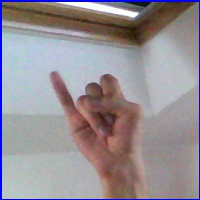

In [14]:
import PIL
img = PIL.Image.open(files[0])
print(f"Image Dims: {img.shape}")
img

**Define target input dimensions**

In [15]:
# size_1_1 = (224, 224)
# size_3_2 = (224, 336)
# size_4_3 = (216, 288)
size_16_9 = (216, 384)
# size_16_9_l = (288, 512)

**Define Transforms**

In [16]:
inspect_default_args(aug_transforms)

,Default Value
mult,1.0
do_flip,True
flip_vert,False
max_rotate,10.0
min_zoom,1.0
max_zoom,1.1
max_lighting,0.2
max_warp,0.2
p_affine,0.75
p_lighting,0.75


In [17]:
item_tfms = [FlipItem(p=1.0), Resize(size_16_9, method=ResizeMethod.Pad, pad_mode=PadMode.Border)]

batch_tfms = [
    Contrast(max_lighting=0.25),
    Saturation(max_lighting=0.25),
    Hue(max_hue=0.05),
    *aug_transforms(
        size=size_16_9, 
        mult=1.0,
        do_flip=False,
        flip_vert=False,
        max_rotate=0.0,
        min_zoom=0.5,
        max_zoom=1.5,
        max_lighting=0.5,
        max_warp=0.2, 
        p_affine=0.0,
        pad_mode=PadMode.Border)
]

**Define batch size**

In [18]:
bs = 128

**Define DataLoaders object**

In [19]:
inspect_default_args(ImageDataLoaders.from_folder)

,Default Value
cls,None
path,None
train,train
valid,valid
valid_pct,None
seed,None
vocab,None
item_tfms,None
batch_tfms,None
bs,64


In [20]:
dls = ImageDataLoaders.from_folder(
    path=dataset_path/'ASL', 
    valid_pct=0.2, 
    bs=bs, 
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms
)

**Verify DataLoaders object**

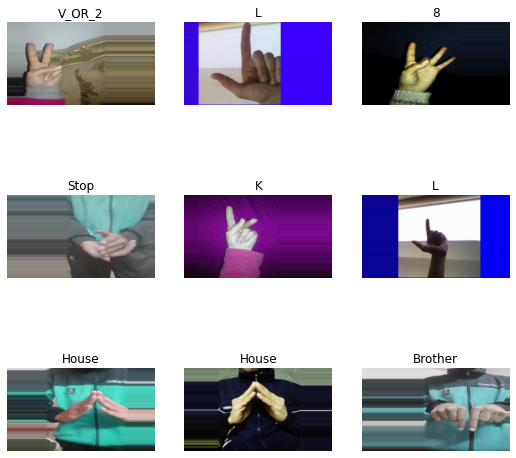

In [21]:
dls.train.show_batch()

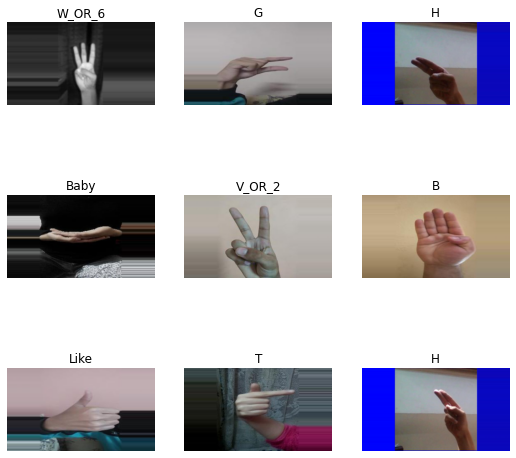

In [22]:
dls.valid.show_batch()

**Apply training split transforms to validation split**

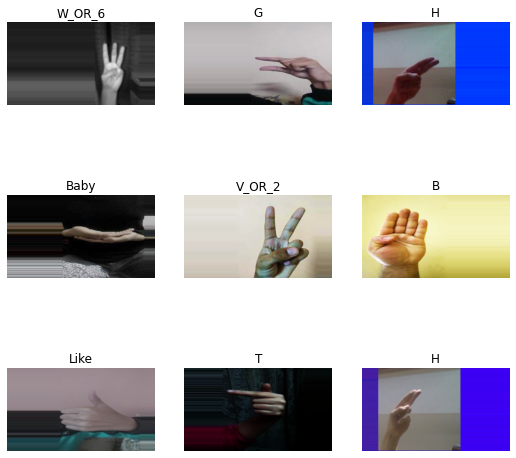

In [23]:
with dls.valid.dataset.set_split_idx(0): dls[1].show_batch()

**Inspect Learner parameters**

In [24]:
inspect_default_args(vision_learner)

,Default Value
dls,None
arch,None
normalize,True
n_out,None
pretrained,True
loss_func,None
opt_func,<function Adam at 0x7fa5e274a560>
lr,0.001
splitter,None
cbs,None


**Define model**

In [25]:
model = resnet18

**Define [metrics](https://docs.fast.ai/metrics.html)**

In [26]:
metrics = [error_rate, accuracy]

**Define Learner object**

In [27]:
learn = vision_learner(dls, model, metrics=metrics).to_fp16()

**Find learning rate**

In [28]:
inspect_default_args(learn.lr_find)

,Default Value
self,None
start_lr,0.0
end_lr,10
num_it,100
stop_div,True
show_plot,True
suggest_funcs,<function valley at 0x7fa5e24996c0>


**Define [suggestion methods](https://docs.fast.ai/callback.schedule.html#Suggestion-Methods)**

In [29]:
suggest_funcs = [valley, minimum, steep]

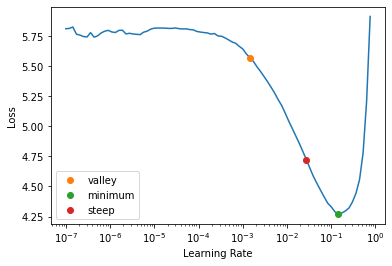

In [30]:
with dls.valid.dataset.set_split_idx(0): learn.lr_find(suggest_funcs=suggest_funcs)

**Define learning rate**

In [32]:
lr = 2e-3
lr

0.002

**Define number of epochs**

In [33]:
epochs = 3

**Fine tune model**

In [34]:
inspect_default_args(learn.fine_tune)

,Default Value
self,None
epochs,None
base_lr,0.002
freeze_epochs,1
lr_mult,100
pct_start,0.3
div,5.0
lr_max,None
div_final,100000.0
wd,None


In [35]:
with dls.valid.dataset.set_split_idx(0): learn.fine_tune(epochs, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.365705,0.175888,0.056305,0.943695,04:52


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.038334,0.021014,0.008103,0.991897,04:56
1,0.012614,0.011383,0.004236,0.995764,04:59
2,0.006508,0.006591,0.003325,0.996675,04:55


**Select a test image**

In [37]:
import PIL

In [38]:
test_file = files[0]
test_file.name

'J1491.jpg'

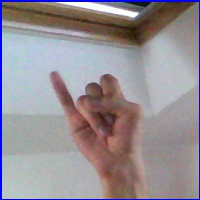

In [39]:
test_img = PIL.Image.open(test_file)
test_img

**Make a prediction on a single image using a file path**

In [40]:
learn.predict(PILImage(test_img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)))

('J',
 TensorBase(22),
 TensorBase([9.6170e-14, 7.7060e-13, 2.5787e-13, 1.1222e-13, 1.5709e-10, 3.6805e-11,
         1.7642e-11, 2.3571e-13, 3.5861e-15, 9.8273e-13, 4.1524e-14, 1.3218e-12,
         7.3592e-14, 3.8404e-14, 4.9230e-12, 8.4399e-12, 2.0167e-11, 3.2757e-13,
         4.0114e-10, 2.3624e-11, 8.3717e-14, 1.9143e-07, 1.0000e+00, 9.7685e-14,
         9.4480e-15, 3.3952e-15, 9.4246e-12, 2.3079e-12, 1.6612e-15, 6.6745e-14,
         3.9778e-14, 2.2675e-11, 1.7859e-14, 1.7659e-11, 5.1701e-11, 8.4209e-14,
         4.6891e-11, 1.3487e-11, 1.0827e-11, 1.0881e-10, 2.6260e-09, 4.2682e-13,
         3.1842e-13, 7.4326e-13, 4.8983e-13, 2.0801e-13, 9.1052e-14, 1.0467e-08,
         2.3752e-14, 1.0124e-09, 6.7431e-11]))

**Make predictions for a group of images**

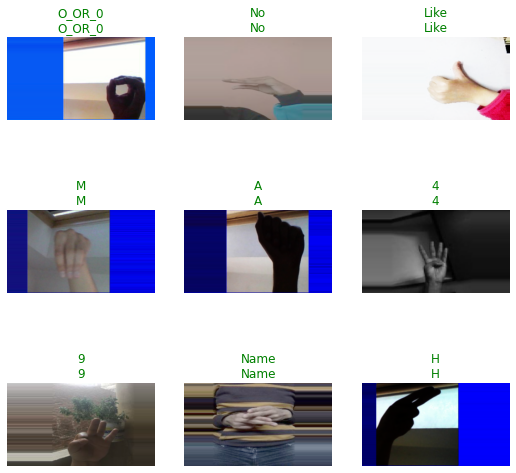

In [41]:
with dls.valid.dataset.set_split_idx(0): learn.show_results()

**Define an Interpretation object**

In [42]:
with dls.valid.dataset.set_split_idx(0): interp = Interpretation.from_learner(learn)

**Plot top losses**

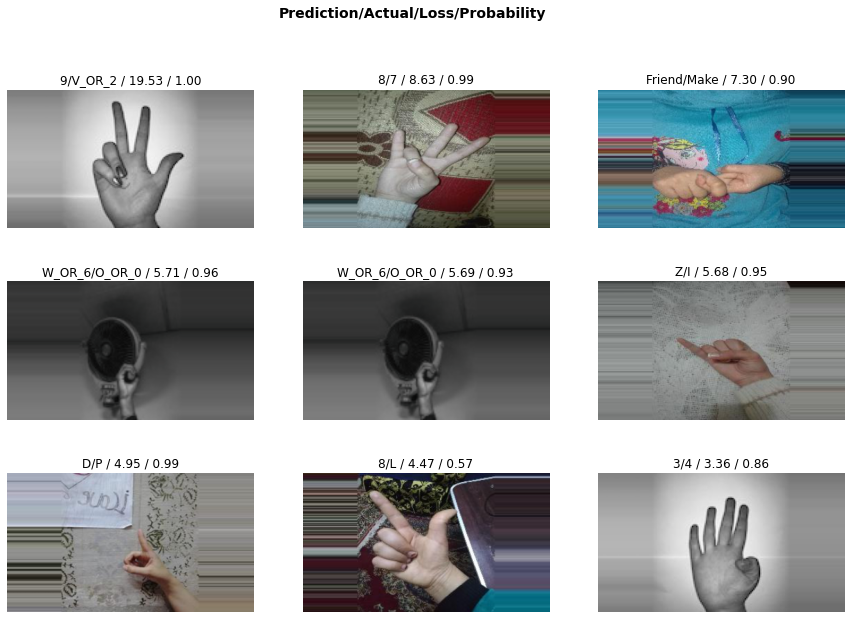

In [43]:
with dls.valid.dataset.set_split_idx(0): interp.plot_top_losses(k=9, figsize=(15,10))

**Inspect the `after_item` pipeline**

In [45]:
learn.dls.after_item

Pipeline: FlipItem -- {'p': 1.0} -> Resize -- {'size': (384, 216), 'method': 'pad', 'pad_mode': 'border', 'resamples': (<Resampling.BILINEAR: 2>, 0), 'p': 1.0} -> ToTensor

**Inspect the `after_batch` pipeline**

In [46]:
learn.dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': (216, 384), 'mode': 'bilinear', 'pad_mode': 'border', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'} -> Contrast -- {'max_lighting': 0.25, 'p': 1.0, 'draw': None, 'batch': False} -> Saturation -- {'max_lighting': 0.25, 'p': 1.0, 'draw': None, 'batch': False} -> Hue -- {'p': 1.0} -> Brightness -- {'max_lighting': 0.5, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

**Reset test image**

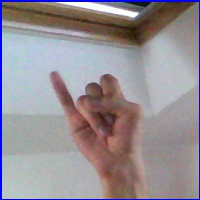

In [47]:
test_img = PIL.Image.open(test_file)
test_img

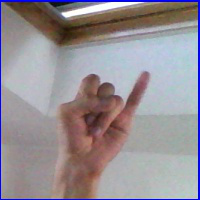

In [48]:
test_img = test_img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
test_img

In [49]:
test_img.size

(200, 200)

In [50]:
min(test_img.size)

200

In [51]:
min_dim = test_img.size.index(min(test_img.size))
max_dim = 1 - min_dim

In [52]:
target_dim = 224

**Set input dims**

In [53]:
inp_dims = [0,0]
inp_dims[min_dim] = target_dim
inp_dims[max_dim] = int(test_img.size[max_dim] / (test_img.size[min_dim]/target_dim))
inp_dims

[224, 224]

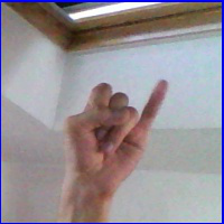

In [54]:
resized_img = test_img.resize(inp_dims)
resized_img

**Convert image to tensor**

In [55]:
img_tensor = tensor(resized_img).permute(2, 0, 1)
img_tensor.shape, img_tensor

(torch.Size([3, 224, 224]),
 tensor([[[  0,   0,   0,  ...,   1,   0,   0],
          [  0,   4,   2,  ...,   9,   2,   0],
          [  5,  82,  99,  ...,  74,   8,   0],
          ...,
          [  3, 127, 154,  ..., 141,   0,   3],
          [  3, 102, 125,  ..., 120,   0,   0],
          [  0,   0,   4,  ...,   0,   1,   0]],
 
         [[  4,   1,   2,  ...,   0,   2,   5],
          [  2,   1,   0,  ...,   0,   0,   5],
          [  0,  75,  91,  ...,  63,   1,   1],
          ...,
          [  3, 126, 150,  ..., 151,   0,   0],
          [  7, 105, 122,  ..., 127,   1,   0],
          [  8,   5,   3,  ...,   4,   6,   2]],
 
         [[253, 254, 255,  ..., 253, 255, 254],
          [244, 220, 199,  ..., 209, 237, 255],
          [212, 222, 180,  ..., 188, 211, 251],
          ...,
          [196, 225, 171,  ..., 238, 204, 255],
          [207, 247, 222,  ..., 242, 218, 255],
          [223, 203, 193,  ..., 219, 247, 254]]], dtype=torch.uint8))

**Scale tensor values**

In [56]:
scaled_tensor = img_tensor.float().div_(255)

**Prepare imagenet mean values**

In [57]:
mean_tensor = tensor(imagenet_stats[0]).view(1,1,-1).permute(2, 0, 1)
mean_tensor.shape, mean_tensor

(torch.Size([3, 1, 1]),
 tensor([[[0.4850]],
 
         [[0.4560]],
 
         [[0.4060]]]))

**Prepare imagenet std values**

In [58]:
std_tensor = tensor(imagenet_stats[1]).view(1,1,-1).permute(2, 0, 1)
std_tensor.shape, std_tensor

(torch.Size([3, 1, 1]),
 tensor([[[0.2290]],
 
         [[0.2240]],
 
         [[0.2250]]]))

**Normalize and batch image tensor**

In [59]:
normalized_tensor = (scaled_tensor - mean_tensor) / std_tensor
batched_tensor = normalized_tensor.unsqueeze(dim=0)
batched_tensor.shape, batched_tensor

(torch.Size([1, 3, 224, 224]),
 tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1179],
           [-2.1179, -2.0494, -2.0837,  ..., -1.9638, -2.0837, -2.1179],
           [-2.0323, -0.7137, -0.4226,  ..., -0.8507, -1.9809, -2.1179],
           ...,
           [-2.0665,  0.0569,  0.5193,  ...,  0.2967, -2.1179, -2.0665],
           [-2.0665, -0.3712,  0.0227,  ..., -0.0629, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.0494,  ..., -2.1179, -2.1008, -2.1179]],
 
          [[-1.9657, -2.0182, -2.0007,  ..., -2.0357, -2.0007, -1.9482],
           [-2.0007, -2.0182, -2.0357,  ..., -2.0357, -2.0357, -1.9482],
           [-2.0357, -0.7227, -0.4426,  ..., -0.9328, -2.0182, -2.0182],
           ...,
           [-1.9832,  0.1702,  0.5903,  ...,  0.6078, -2.0357, -2.0357],
           [-1.9132, -0.1975,  0.1001,  ...,  0.1877, -2.0182, -2.0357],
           [-1.8957, -1.9482, -1.9832,  ..., -1.9657, -1.9307, -2.0007]],
 
          [[ 2.6051,  2.6226,  2.6400,  ...,  2.6051,  

**Pass tensor to model**

In [60]:
with torch.no_grad():
    preds = learn.model(batched_tensor.cuda())
preds

TensorBase([[-4.9931e+00, -1.9711e+00, -3.3677e+00, -3.0452e+00,  3.9567e+00,
          3.9293e+00,  3.1657e+00, -5.3549e+00, -7.9026e+00, -1.5491e+00,
         -2.4086e+00, -2.6251e+00, -4.0321e+00, -7.3666e+00, -1.0557e+00,
         -3.2344e-01,  4.7887e+00, -4.8819e+00,  6.5188e+00,  1.1152e+00,
         -5.9519e-01,  1.1730e+01,  3.0779e+01, -4.4505e+00, -1.0000e+01,
         -9.1124e+00, -3.7176e-01, -4.2437e+00, -8.6924e+00, -1.5119e+00,
         -8.4118e+00,  9.1559e-01, -7.6669e+00,  1.7187e+00,  2.0639e+00,
         -4.0788e+00,  9.0079e+00, -2.8547e-02,  1.1223e+00, -3.2541e-02,
          8.9209e+00, -4.2307e+00, -3.6343e+00, -9.8461e-01, -4.2557e+00,
         -2.2238e+00, -5.9167e+00,  7.0386e+00, -7.7322e+00,  4.3321e+00,
         -3.1247e-01]], device='cuda:0')

In [61]:
torch.nn.functional.softmax(preds, dim=1)

TensorBase([[2.9133e-16, 5.9815e-15, 1.4800e-15, 2.0433e-15, 2.2450e-12, 2.1844e-12,
         1.0179e-12, 2.0287e-16, 1.5878e-17, 9.1219e-15, 3.8617e-15, 3.1101e-15,
         7.6160e-16, 2.7138e-17, 1.4940e-14, 3.1072e-14, 5.1585e-12, 3.2557e-16,
         2.9103e-11, 1.3097e-13, 2.3678e-14, 5.3343e-09, 1.0000e+00, 5.0120e-16,
         1.9486e-18, 4.7354e-18, 2.9607e-14, 6.1632e-16, 7.2077e-18, 9.4674e-15,
         9.5424e-18, 1.0727e-13, 2.0099e-17, 2.3949e-13, 3.3822e-13, 7.2685e-16,
         3.5069e-10, 4.1729e-14, 1.3190e-13, 4.1563e-14, 3.2148e-10, 6.2438e-16,
         1.1337e-15, 1.6041e-14, 6.0902e-16, 4.6457e-15, 1.1568e-16, 4.8942e-11,
         1.8828e-17, 3.2679e-12, 3.1415e-14]], device='cuda:0')

**Process model output**

In [62]:
preds.argmax()

TensorBase(22, device='cuda:0')

In [63]:
torch.nn.functional.softmax(preds, dim=1)[0][preds.argmax()]

TensorBase(1., device='cuda:0')

**Get the class labels**

In [64]:
learn.dls.vocab

['1', '3', '4', '5', '7', '8', '9', 'A', 'B', 'Baby', 'Brother', 'C', 'D', 'Dont_like', 'E', 'F', 'Friend', 'G', 'H', 'Help', 'House', 'I', 'J', 'K', 'L', 'Like', 'Love', 'M', 'Make', 'More', 'N', 'Name', 'No', 'O_OR_0', 'P', 'Pay', 'Play', 'Q', 'R', 'S', 'Stop', 'T', 'U', 'V_OR_2', 'W_OR_6', 'With', 'X', 'Y', 'Yes', 'Z', 'nothing']

**Get the predicted class label**

In [65]:
learn.dls.vocab[preds.argmax()]

'J'

In [66]:
learn.dls.vocab[torch.nn.functional.softmax(preds, dim=1).argmax()]

'J'

**Define ONNX file name**

In [67]:
onnx_file_name = f"{dataset_path.name}-{learn.arch.__name__}.onnx"
onnx_file_name

'asl-and-some-words-resnet18.onnx'

**Export trained model to ONNX**

In [70]:
torch.onnx.export(learn.model.cpu(),
                  batched_tensor,
                  onnx_file_name,
                  export_params=True,
                  opset_version=9,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  # Uncomment the line below to unlock input dimensions
                  dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

**Export class labels**

In [72]:
import json

class_labels = {"classes": list(learn.dls.vocab)}
class_labels_file_name = f"{dataset_path.name}-classes.json"

with open(class_labels_file_name, "w") as write_file:
    json.dump(class_labels, write_file)